In [59]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import os

original_img = cv2.imread('./VC_2425_Project_public/images/G000_IMG062.jpg')

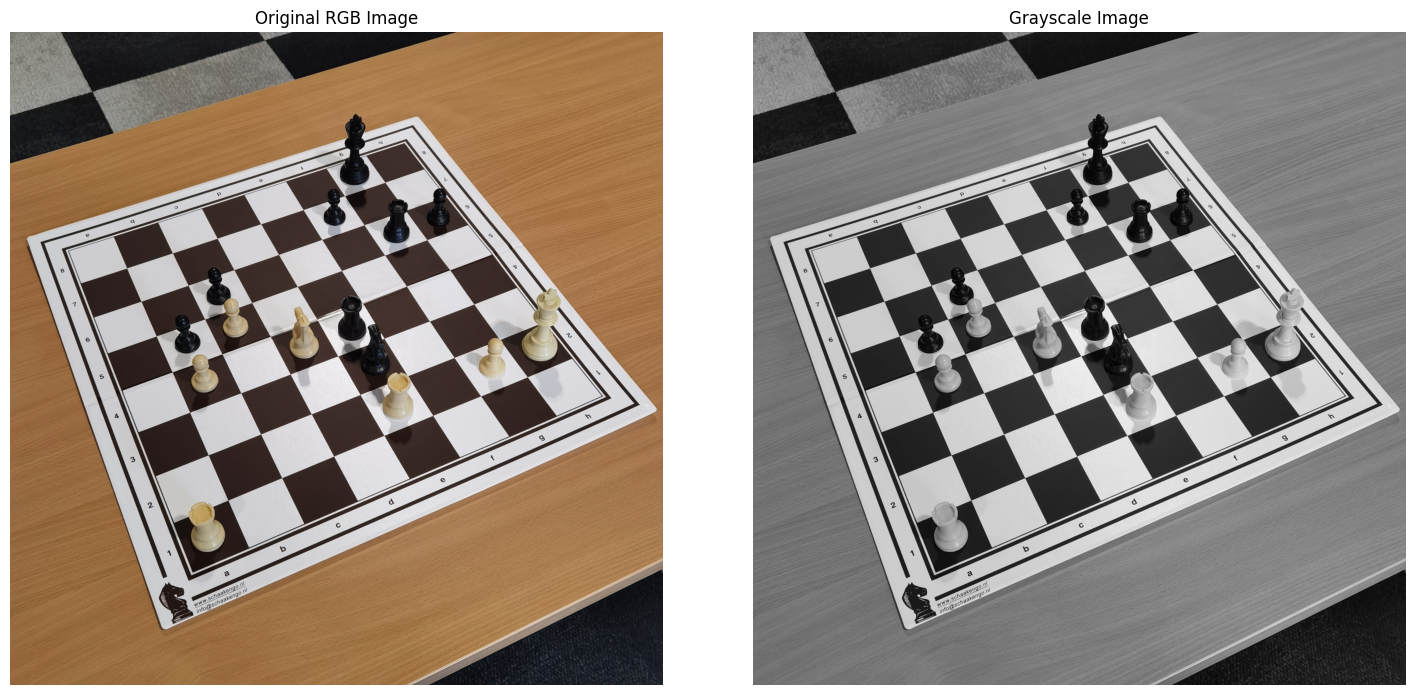

In [60]:
rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 7))

# Display RGB image on the left
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.axis('off')
plt.title('Original RGB Image')

# Display grayscale image on the right
plt.subplot(1, 2, 2)
plt.imshow(gray_img, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()

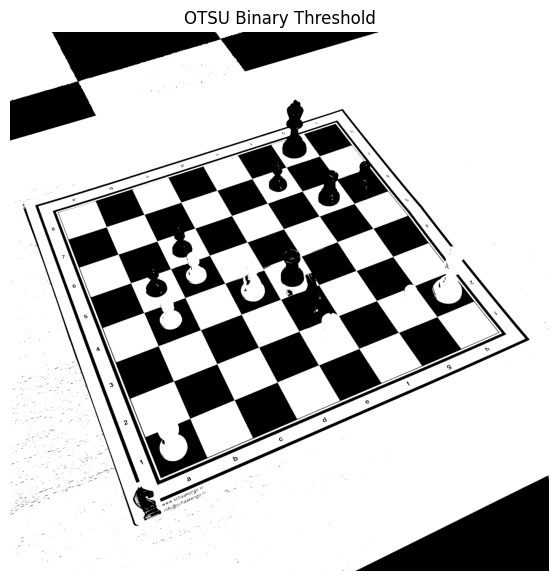

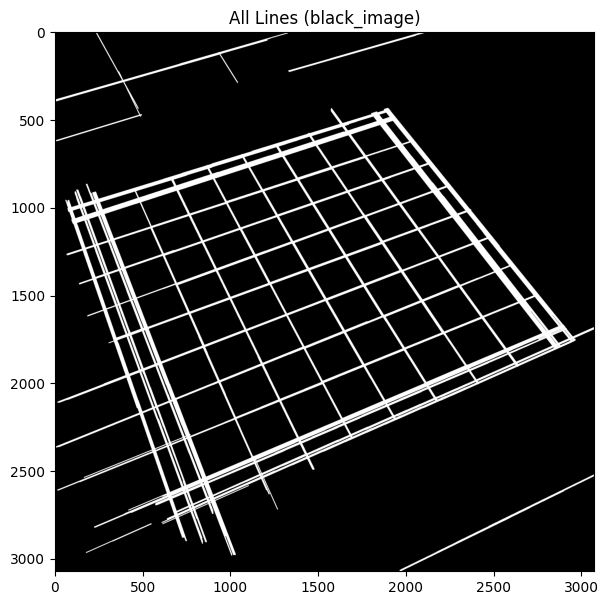

In [61]:
# Apply OTSU thresholding
ret, otsu_binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Show the binary image after OTSU threshold
plt.figure(figsize=(7, 7))
plt.title("OTSU Binary Threshold")
plt.imshow(otsu_binary, cmap="gray")
plt.axis('off')
plt.show()

# Canny edge detection
canny_image = cv2.Canny(otsu_binary, 20, 255)

# Dilation
kernel = np.ones((7, 7), np.uint8)
dilation_image = cv2.dilate(canny_image, kernel, iterations=1)

# Hough Lines
lines = cv2.HoughLinesP(dilation_image, 1, np.pi / 180, threshold=500, minLineLength=150, maxLineGap=120)


# Create an image that contains only black pixels
black_image = np.zeros_like(dilation_image)

# Draw only lines that are output of HoughLinesP function to the "black_image"
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # draw only lines to the "black_image"
        cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

# Dilation
kernel = np.ones((3, 3), np.uint8)
black_image = cv2.dilate(black_image, kernel, iterations=1)

plt.figure(figsize=(9,7))
plt.title("All Lines (black_image)")
plt.imshow(black_image,cmap="gray")

In [62]:
contours, _ = cv2.findContours(black_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area

if contours:
    chessboard_contour = contours[0]  # Largest contour

In [63]:
epsilon = 0.02 * cv2.arcLength(chessboard_contour, True)  # Adjust factor if needed
approx_corners = cv2.approxPolyDP(chessboard_contour, epsilon, True)

if len(approx_corners) == 4:
    corners = np.squeeze(approx_corners)  # Remove extra dimensions
else:
    print("Error: Did not find exactly 4 corners!")

Error: Did not find exactly 4 corners!


In [64]:
def order_corners(corners):
    # Sort by y-coordinates (top 2 first, bottom 2 last)
    sorted_by_y = sorted(corners, key=lambda p: p[1])

    # Top-left & top-right (smallest y-values)
    top_two = sorted(sorted_by_y[:2], key=lambda p: p[0])  # Sort left to right
    # Bottom-left & bottom-right (largest y-values)
    bottom_two = sorted(sorted_by_y[2:], key=lambda p: p[0])  # Sort left to right

    return np.array([top_two[0], top_two[1], bottom_two[0], bottom_two[1]], dtype="float32")

if len(corners) == 4:
    ordered_corners = order_corners(corners)

    # Define new image size (e.g., 800x800 for better resolution)
    board_size = 800
    dst_corners = np.array([
        [0, 0], [board_size - 1, 0], 
        [0, board_size - 1], [board_size - 1, board_size - 1]
    ], dtype="float32")

    # Compute perspective transform matrix and warp
    matrix = cv2.getPerspectiveTransform(ordered_corners, dst_corners)
    warped_board = cv2.warpPerspective(gray_img, matrix, (board_size, board_size))

    plt.figure(figsize=(7,7))
    plt.title("Warped Chessboard")
    plt.imshow(warped_board, cmap="gray")